In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Cargar los archivos Excel
df_2024_2= pd.read_excel("../data/processed/df_objetivo/2024-2.xlsx")

# Crear variable objetivo

In [3]:
# Crear la variable de avance esperado según el número de matrículas
# Se asume que el avance ideal es proporcional al número de matrículas (e.g. 6 matrículas → 48%)
df_2024_2["AVANCE_ESPERADO"] = df_2024_2["NUMERO_MATRICULAS"] * 8
df_2024_2["ATRASO_PORCENTUAL"] = df_2024_2["AVANCE_ESPERADO"] - df_2024_2["AVANCE_CARRERA"]

# Evitar negativos: si el atraso es menor que 0, ponerlo en 0
df_2024_2["ATRASO_PORCENTUAL"] = df_2024_2["ATRASO_PORCENTUAL"].clip(lower=0)

Umbral sugerido (percentil 80): 17.860000000000014


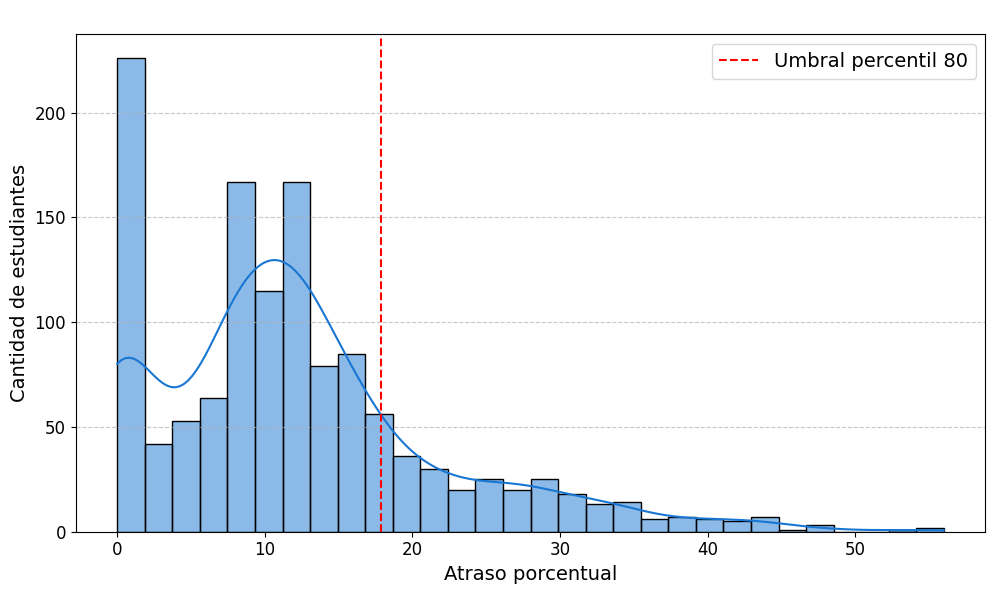

In [4]:
umbral = df_2024_2["ATRASO_PORCENTUAL"].quantile(0.8)
print(f"Umbral sugerido (percentil 80): {umbral}")


plt.figure(figsize=(10, 6))
sns.histplot(df_2024_2["ATRASO_PORCENTUAL"], bins=30, kde=True, color="#1976D2", edgecolor="black")
plt.axvline(umbral, color="red", linestyle="--", label="Umbral percentil 80")
plt.xlabel("Atraso porcentual", fontsize=14)
plt.ylabel("Cantidad de estudiantes", fontsize=14)
plt.title(" ", fontsize=16, fontweight="bold")
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

El histograma de la variable "atraso porcentual" muestra que la mayoría de los estudiantes presentan un atraso bajo o nulo en su avance académico, concentrándose principalmente en valores cercanos a cero. Sin embargo, existe una proporción menor de estudiantes con atrasos significativamente mayores, lo que genera una cola hacia la derecha en la distribución. Esta observación indica que los casos de mayor atraso son menos frecuentes pero relevantes para identificar posibles riesgos de deserción. Por esta razón, se selecciona como umbral el percentil 80 (17.86%), de modo que solo el 20% de los estudiantes con mayor atraso sean clasificados como "en riesgo", permitiendo así enfocar la intervención en quienes realmente presentan un rezago académico considerable respecto al resto de la cohorte.

In [5]:

umbral_atraso = 17.86

# Condiciones para calcular el porcentaje de atraso
condicion_atraso = df_2024_2["ATRASO_PORCENTUAL"] > umbral_atraso
condicion_papa = df_2024_2["PAPA"] < 3.6

# Estudiantes con más de 4 matrículas
condicion_general = (df_2024_2["NUMERO_MATRICULAS"] > 4) & condicion_atraso & condicion_papa
# Estudiantes con 4 o menos matrículas
condicion_novato = (df_2024_2["NUMERO_MATRICULAS"] <= 4) & condicion_papa

# Condiciones adicionales para estudiantes de nuevo ingreso sin PAPA o matrícula 1
condicion_sin_papa = df_2024_2["PAPA"].isna()
condicion_estrato_0 = df_2024_2["ESTRATO"] == 0
condicion_estrato_1_pbm_bajo = (df_2024_2["ESTRATO"] == 1) & (df_2024_2["PBM_CALCULADO"] < 3)

condicion_socioeconomica = condicion_sin_papa & (condicion_estrato_0 | condicion_estrato_1_pbm_bajo)

df_2024_2["RIESGO_DESERCION"] = (
    (condicion_general | condicion_novato) | condicion_socioeconomica
).astype(int)

# Ver distribución
riesgo_desercion_distribution = df_2024_2["RIESGO_DESERCION"].value_counts()

# Ejemplos en riesgo bajo la nueva condición
en_riesgo = df_2024_2[df_2024_2["RIESGO_DESERCION"] == 1][
    ["NUMERO_MATRICULAS", "AVANCE_CARRERA", "AVANCE_ESPERADO", 
     "ATRASO_PORCENTUAL", "PAPA"]
].head()

riesgo_desercion_distribution, en_riesgo



(0    1129
 1     165
 Name: RIESGO_DESERCION, dtype: int64,
     NUMERO_MATRICULAS  AVANCE_CARRERA  AVANCE_ESPERADO  ATRASO_PORCENTUAL  \
 10                6.0            24.6             48.0               23.4   
 12                4.0            19.9             32.0               12.1   
 16                6.0            26.0             48.0               22.0   
 27                8.0            35.6             64.0               28.4   
 30                4.0            16.7             32.0               15.3   
 
     PAPA  
 10   3.4  
 12   3.5  
 16   3.3  
 27   3.5  
 30   3.4  )

### Eliminar registros duplicados

In [6]:
# Mostrar todos los registros donde DOCUMENTO está duplicado
duplicados = df_2024_2[df_2024_2["DOCUMENTO"].duplicated(keep=False)]

print(f'Cantidad de registros duplicados: {df_2024_2["DOCUMENTO"].duplicated().sum()}')
duplicados



Cantidad de registros duplicados: 11


,PLAN,AVANCE_CARRERA,DOCUMENTO,DOCUMENTO__,COINCIDE,SUBACCESO,APERTURA,GENERO,EDAD,NUMERO_MATRICULAS,...,NACIONALIDAD,VICTIMAS_DEL_CONFLICTO,DISCAPACIDAD,CARACTER_COLEGIO,MUNICIPIO_RESIDENCIA_FAM,NODO_INICIO,PUNTAJE_ADMISION,AVANCE_ESPERADO,ATRASO_PORCENTUAL,RIESGO_DESERCION
68,GEOGRAFÍA,70.9,a71a2dfca1249b94be5051442b248b09,3a245ca19b5caa86030b85ca914e4eb3,No,PROGRAMA DE ADMISIÓN ESPECIAL PARA LOS PROGRAM...,2020-2S,HOMBRE,27,9.0,...,COLOMBIA,NO,NO,Plantel Oficial,MANAURE BALCÓN DEL CESAR,Estudiantes que deben nivelar 3 asignaturas,NaN,72.0,1.1,0
107,GEOGRAFÍA,70.9,a71a2dfca1249b94be5051442b248b09,374a04a1aa99cb628ff9503ef37304ad,No,PROGRAMA DE ADMISIÓN ESPECIAL PARA LOS PROGRAM...,2020-2S,HOMBRE,27,9.0,...,COLOMBIA,NO,NO,Plantel Oficial,MANAURE BALCÓN DEL CESAR,Estudiantes que deben nivelar 3 asignaturas,NaN,72.0,1.1,0
155,GESTIÓN CULTURAL Y COMUNICATIVA,54.7,2cb4039999ea3ef6e7369bb80f02ea7c,003d79b39e76e46e0bac40f7f2ce2dba,No,PROGRAMA DE ADMISIÓN ESPECIAL PARA LOS PROGRAM...,2021-1S,HOMBRE,22,8.0,...,COLOMBIA,NO,NO,Plantel Oficial,SAN DIEGO,Estudiantes que deben nivelar 3 asignaturas,402.300,64.0,9.3,0
161,INGENIERÍA BIOLÓGICA,0.0,a682cbffff84b2d88aaf4a573b506806,3a4b9610c42ff41c88f8bbc3a0266e7b,No,VÍCTIMAS DEL CONFLICTO ARMADO EN COLOMBIA,2024-2S,MUJER,30,1.0,...,COLOMBIA,SI,NO,Plantel Oficial,VALLEDUPAR,Estudiantes que deben nivelar 3 asignaturas,487.344,8.0,8.0,0
189,INGENIERÍA MECATRÓNICA,30.8,ae2dc5a9c7c4037e2fe86b72cb7a2b09,5eda8b84899f2ebf64b59a4ec95279fe,No,PROGRAMA DE ADMISIÓN ESPECIAL PARA LOS PROGRAM...,2022-2S,HOMBRE,21,5.0,...,COLOMBIA,NO,NO,Plantel Oficial,MANAURE BALCÓN DEL CESAR,Estudiantes que deben nivelar 3 asignaturas,596.796,40.0,9.2,0
231,BIOLOGÍA,36.9,3202dd59396a0ef0f83b280f55fefae6,b86993d8517a4278a700e6bcf93c3638,No,PROGRAMA DE ADMISIÓN ESPECIAL PARA LOS PROGRAM...,2022-1S,MUJER,20,6.0,...,COLOMBIA,NO,NO,Plantel Oficial,AGUSTÍN CODAZZI,Estudiantes que deben nivelar 3 asignaturas,NaN,48.0,11.1,0
283,GEOGRAFÍA,70.9,a71a2dfca1249b94be5051442b248b09,04bbf214ad8f6f3efa7ed21786c6199a,No,PROGRAMA DE ADMISIÓN ESPECIAL PARA LOS PROGRAM...,2020-2S,HOMBRE,27,9.0,...,COLOMBIA,NO,NO,Plantel Oficial,MANAURE BALCÓN DEL CESAR,Estudiantes que deben nivelar 3 asignaturas,NaN,72.0,1.1,0
374,GESTIÓN CULTURAL Y COMUNICATIVA,54.7,2cb4039999ea3ef6e7369bb80f02ea7c,ab23a902e7244f659f133b132e6cc01e,No,PROGRAMA DE ADMISIÓN ESPECIAL PARA LOS PROGRAM...,2021-1S,HOMBRE,22,8.0,...,COLOMBIA,NO,NO,Plantel Oficial,SAN DIEGO,Estudiantes que deben nivelar 3 asignaturas,402.300,64.0,9.3,0
471,INGENIERÍA BIOLÓGICA,0.0,a682cbffff84b2d88aaf4a573b506806,3af840dd52939bb7564f18e732fe3392,No,VÍCTIMAS DEL CONFLICTO ARMADO EN COLOMBIA,2024-2S,MUJER,30,1.0,...,COLOMBIA,SI,NO,Plantel Oficial,VALLEDUPAR,Estudiantes que deben nivelar 3 asignaturas,487.344,8.0,8.0,0
496,BIOLOGÍA,36.9,3202dd59396a0ef0f83b280f55fefae6,3f896f834d17eb65fcfd77652db06684,No,PROGRAMA DE ADMISIÓN ESPECIAL PARA LOS PROGRAM...,2022-1S,MUJER,20,6.0,...,COLOMBIA,NO,NO,Plantel Oficial,AGUSTÍN CODAZZI,Estudiantes que deben nivelar 3 asignaturas,NaN,48.0,11.1,0


In [7]:
# Eliminar duplicados y dejar solo la primera aparición de cada DOCUMENTO
df_2024_2 = df_2024_2.drop_duplicates(subset="DOCUMENTO", keep="first")

print(df_2024_2["DOCUMENTO"].duplicated().sum())


0


### Exportar a Excel

In [ ]:
# Guardar el dataframe con la variable objetivo
df_objetivo = df_2024_2.copy()
df_objetivo.to_excel("../data/processed/df_objetivo/df_objetivo_riesgo_desercion.xlsx", index=False)

In [62]:
# Exportar el dataset con la variable objetivo
distribucion = df_objetivo["RIESGO_DESERCION"].value_counts(normalize=True) * 100
print(distribucion)

0    87.139517
1    12.860483
Name: RIESGO_DESERCION, dtype: float64


### Cargar el nuevo archivo

In [ ]:
# Cargar el archivo exportado
df = pd.read_excel("../data/processed/df_objetivo/df_objetivo_riesgo_desercion.xlsx", sheet_name='Hoja1')

# Ver distribución de la variable objetivo
conteo = df["RIESGO_DESERCION"].value_counts()
proporcion = df["RIESGO_DESERCION"].value_counts(normalize=True)

balanceo = pd.concat([conteo, proporcion], axis=1)
balanceo.columns = ["conteo", "proporcion"]
print(balanceo)

   conteo  proporcion
0    1117    0.870616
1     166    0.129384


### Documentos con etiquetas reales de deserción

In [ ]:

df_documentos = pd.read_excel("../data/processed/df_objetivo/df_objetivo_riesgo_desercion.xlsx", sheet_name='Hoja2')
df_documentos


,DOCUMENTO
0,3b28cdca231e0724f92b97ce183f66a0
1,9ad6df14a2eb26173ccc5a23ddd54a96
2,3a870cff33edc407df7b386b855952d2
3,c56f8f5949b31d04ddd5ddb50d16ce9f
4,be2fd515f7b61d7e38518b38465a4a5f
...,...
567,58ecfb9e0ca9d9c83d33d036c9a37bcd
568,d15203ecd315aa6d48722c04f48738a5
569,a98bf39ac1408bbc851ef57e9a4032a5
570,e31c2f21d4c8a9b73c3da545c587bbfc


In [80]:
# Ver cuántos DOCUMENTO de df_documentos están en df
coinciden = df_documentos["DOCUMENTO"].isin(df["DOCUMENTO"]).sum()
print(f"Cantidad de DOCUMENTOS de df_documentos que están en df: {coinciden}")

Cantidad de DOCUMENTOS de df_documentos que están en df: 44


### Agregar etiquetas reales a los documentos coincidentes

In [74]:
# Identificar los DOCUMENTO que coinciden
documentos_coinciden = df_documentos["DOCUMENTO"].isin(df["DOCUMENTO"])

# Obtener la lista de DOCUMENTO que coinciden
lista_documentos = df_documentos.loc[documentos_coinciden, "DOCUMENTO"]

# Filtrar en df los registros con DOCUMENTO en la lista
mask = df["DOCUMENTO"].isin(lista_documentos)

# Cuántos ya estaban etiquetados como 1
ya_en_1 = (df.loc[mask, "RIESGO_DESERCION"] == 1).sum()

# Cuántos no estaban etiquetados como 1
no_en_1 = (df.loc[mask, "RIESGO_DESERCION"] != 1).sum()

print(f"Ya estaban etiquetados como 1: {ya_en_1}")
print(f"No estaban etiquetados como 1: {no_en_1}")

# Cambiar el valor de RIESGO_DESERCION a 1 para esos DOCUMENTO
df.loc[mask, "RIESGO_DESERCION"] = 1

Ya estaban etiquetados como 1: 19
No estaban etiquetados como 1: 22


In [82]:
# Ver distribución de la variable objetivo
conteo = df["RIESGO_DESERCION"].value_counts()
proporcion = df["RIESGO_DESERCION"].value_counts(normalize=True)

balanceo = pd.concat([conteo, proporcion], axis=1)
balanceo.columns = ["conteo", "proporcion"]
print(balanceo)

   conteo  proporcion
0    1095    0.853468
1     188    0.146532


### Exportar nuevamente el dataset

In [ ]:
# Guardar el dataframe con la variable objetivo
df_target = df.copy()
df_target.to_excel("../data/processed/df_objetivo/df_objetivo_riesgo_real.xlsx", index=False)